In [2]:
import geopandas as gpd
import re
from geofeather import from_geofeather
from geofeather import to_geofeather

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [3]:
from helper_funciton import *

## Read data - Statewide

In [4]:
start_time = datetime.now()

parcel_whole = from_geofeather("data/ParcelData/statewide_parcel_data.feather")
address_whole = from_geofeather("data/AddressData/statewide_address_data.feather")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 66558.26ms


In [5]:
parcel_quincy = parcel_whole[parcel_whole['CITY'] == "QUINCY"]
address_quincy = address_whole[address_whole['COMMUNITY_NAME'] == "QUINCY"]

In [9]:
parcel_quincy = parcel_quincy.reset_index()
address_quincy = address_quincy.reset_index()

In [10]:
to_geofeather(parcel_quincy, "./data/test_data/quincy_parcel.feather")
to_geofeather(address_quincy, "./data/test_data/quincy_address.feather")

## Read data - Test data

In [4]:
start_time = datetime.now()

parcel_quincy = from_geofeather("./data/test_data/quincy_parcel.feather")
address_quincy = from_geofeather("./data/test_data/quincy_address.feather")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 966.76ms


### Read use code

In [15]:
state_use_code = gpd.read_file("data/state_use_codes_lookup_table/")

## Classify using style

In [56]:
for name_, df_ in parcel_quincy.groupby("STYLE"):
    print(name_)

2 Fam Conver
2 Fam Flat
3 Fam Conv
3 Fam Flat
4 Fam
Apartments
Armory
Assisted Living Fac
Auditorium
Auto Dealer
Bank
Boarding House
Bowling/Arena
Bungalow
Cape Cod
Car Wash
Child/Daycare
Churches
City/Town Hall
Clubs/Lodges
Coin-op CarWsh
Colonial
Commercial
Condo GR
Condo Office
Condo TH
Conventional
Department Store
Dormitory
Dry Cln/Laundr
Family Duplex
Fast Food Rest
Finan Inst.
Fire Station
Food Process
Funeral Home
Furn Showroom
Gambrel
Garage/Municipal
Garage/Office
Gas Mart
Gas Station
Health Club
High Rise Apt
Hotel
Ind/Whse/Ofc
Indust Condo
Industrial
Library
Med Pro Building
Modern/Contemp
Motel
New High Tech School
Nursing Home
Ofc/Apt
Office Bldg
Office Condo Conv
Office Ovr Retail
Other Federal
Other Municip
Other State
Outbuildings
Parking Garage
Plaza
Post Office
Pre-Eng Garage
Pre-Eng Warehs
Profess. Bldg
Quonset Bldg
Raised Ranch
Ranch
Res Type Commercial
Research/Devel
Restaurant
Retail Condo
School/College
Self Storage
Serv Shop/Gar
Skating Arena
Split Level
Store


In [8]:
res_dic = {
    "2 Fam Conver": 2,
    "2 Fam Flat": 2,
    "3 Fam Conv": 3,
    "3 Fam Flat": 3,
    "4 Fam": 4,
    "Apartments": 1,
    "Bungalow": 1,
    "Boarding House": 1,
    "Colonial": 1,
    "Condo GR": 1,
    "Condo TH": 1,
    "Conventional": 1,
    "Dormitory": 1,
    "Family Duplex": 2,
    "Gambrel": 1,
    "High Rise Apt": 1,
    "Indust Condo": 1,
    "Industrial": 1,
    "Raised Ranch": 1,
    "Retail Condo": 1,
    "Split Level": 1,
    "Cape Cod": 1
}
use_code_dict = {
    "101": 1,
    "102": 1,
    "103": 1,
    "104": 2,
    "105": 3,
    "109": 2.5,
    "111": 4.5,
    "112": 8.5,
    "113": 100.5,
    # Need extra care
    "959": 1
}

In [32]:
parcel_quincy_conv = parcel_quincy.to_crs("EPSG:4326")

In [16]:
parcel_quincy_conv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26537 entries, 0 to 26536
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       26537 non-null  int64   
 1   MAP_PAR_ID  18631 non-null  object  
 2   LOC_ID      26537 non-null  object  
 3   POLY_TYPE   26537 non-null  object  
 4   MAP_NO      26526 non-null  object  
 5   SOURCE      26537 non-null  object  
 6   PLAN_ID     1 non-null      object  
 7   LAST_EDIT   26537 non-null  int64   
 8   BND_CHK     188 non-null    object  
 9   NO_MATCH    26537 non-null  object  
 10  TOWN_ID     26537 non-null  int64   
 11  PROP_ID     26440 non-null  object  
 12  BLDG_VAL    26537 non-null  int64   
 13  LAND_VAL    26537 non-null  int64   
 14  OTHER_VAL   26537 non-null  int64   
 15  TOTAL_VAL   26537 non-null  int64   
 16  FY          26537 non-null  int64   
 17  LOT_SIZE    26537 non-null  float64 
 18  LS_DATE     26440 non-null  object  
 

In [9]:
def count_res(X, dict_=res_dic):
    count = 0
    for val in X:
        if val in res_dic.keys():
            count += res_dic[val]
    return count

In [10]:
def dump_filter(X):
    return X

In [11]:
def dump_filter_not_none(X):
    for val in X:
        if val != "None": return val
    return X

In [12]:
def compose_style(style_set):
    s = ""
    for style in style_set:
        s += style + " | "
    return s[:-3]

In [13]:
def count_parcels(parcel_df, dict_=res_dic):
    id_ = []
    count_ = []
    style_desc = []
    geometry_ = []
    for loc_id_, df_ in parcel_df.groupby("LOC_ID"):
        count_temp = 0
        string_set = set()
        for style_ in df_["STYLE"]:
            string_set.add(str(style_))
            if style_ in dict_.keys():
                count_temp += dict_[style_]

        id_.append(loc_id_)
        count_.append(count_temp)
        style_desc.append(compose_style(string_set))
        geometry_.append(df_['geometry'].iloc[0])

    return id_, count_, style_desc, geometry_

In [47]:
def count_parcels_by_usecode(parcel_df, usecode_dict):
    count_usecode = []

    for loc_id_, df_ in parcel_df.groupby("LOC_ID"):
        count_temp = 0
        for us in df_["USE_CODE"]:
            if us and us[:-1] in usecode_dict.keys():
                count_temp += usecode_dict[us[:-1]]

        count_usecode.append(count_temp)

    return count_usecode

In [14]:
def generate_gpd_dataframe(feature_list, feature_names=[]):
    if len(feature_names) < len(feature_list) - 1:
        feature_names = [str(i) for i in range(len(feature_list) - 1)]
    df = pd.DataFrame(list(zip(*feature_list[:-1])), columns=feature_names)
    df['geometry'] = feature_list[-1]

    gdf = gpd.GeoDataFrame(df)
    return gdf

In [33]:
test_loc_id, test_unit_count, test_style_string, test_geometry = count_parcels(parcel_quincy_conv)

In [48]:
test_use_code_count = count_parcels_by_usecode(parcel_quincy_conv, use_code_dict)

In [49]:
print(len(test_use_code_count))
print(len(test_unit_count))

20275
20275


In [51]:
test_gdf = generate_gpd_dataframe([test_loc_id, test_unit_count, test_use_code_count, test_style_string, test_geometry], ["LOC_ID", "UNIT_COUNT", "UNIT_COUNT_USE_CODE", "STYLE"])

In [52]:
test_gdf.head()

,LOC_ID,UNIT_COUNT,UNIT_COUNT_USE_CODE,STYLE,geometry
0,F_775349_2913131,0,0.0,None,"POLYGON ((-71.05863 42.23951, -71.05916 42.239..."
1,F_775713_2913360,0,0.0,None,"POLYGON ((-71.05697 42.24151, -71.05697 42.241..."
2,F_776140_2913906,0,0.0,Pre-Eng Warehs,"POLYGON ((-71.05696 42.24151, -71.05696 42.241..."
3,F_776785_2904919,0,0.0,Skating Arena,"MULTIPOLYGON (((-71.04710 42.22834, -71.04695 ..."
4,F_777364_2914835,0,0.0,None,"POLYGON ((-71.04975 42.24545, -71.05294 42.243..."


In [30]:
test_agg_map = draw_debug_plot([], test_gdf['geometry'], popup_polygons=[s + "<br>Unit Count: " + str(c) for s, c in zip(test_gdf['STYLE'], test_gdf['UNIT_COUNT'])])
test_agg_map.save('./maps/test_agg_map_quincy.html')

In [95]:
for count_, df_ in test_count_agg["STYLE"].groupby("count_res"):
    print("Number of residential units: {}, Count: {}".format(count_, len(df_)))

Number of residential units: 0, Count: 5913
Number of residential units: 1, Count: 9934
Number of residential units: 2, Count: 3103
Number of residential units: 3, Count: 648
Number of residential units: 4, Count: 509
Number of residential units: 5, Count: 25
Number of residential units: 6, Count: 13
Number of residential units: 7, Count: 8
Number of residential units: 8, Count: 13
Number of residential units: 9, Count: 9
Number of residential units: 10, Count: 2
Number of residential units: 11, Count: 2
Number of residential units: 12, Count: 7
Number of residential units: 13, Count: 4
Number of residential units: 14, Count: 7
Number of residential units: 15, Count: 3
Number of residential units: 16, Count: 2
Number of residential units: 17, Count: 1
Number of residential units: 18, Count: 2
Number of residential units: 20, Count: 4
Number of residential units: 21, Count: 2
Number of residential units: 22, Count: 2
Number of residential units: 23, Count: 3
Number of residential units:

### Sjoin

In [ ]:
def join_two_dataset_state_map(parcel_df, address_df_map, keyword="CITY"):
    start_time = datetime.now()
    
    m = {}
    for name, p_df in parcel_df.groupby(keyword):
        start_time_2 = datetime.now()

        a_df = address_df_map[address_df_map["COMMUNITY_NAME"] == name]
        join_two_dataset_map(a_df, p_df, m, "LOC_ID")
        print("%s, cost: %.2dms" %(name, (datetime.now() - start_time_2).total_seconds() * 1000))
        print("res length: %d" %(len(m)))

    end_time = datetime.now()
    print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))
    return m

In [53]:
address_quincy_loc = gpd.GeoDataFrame(address_quincy['geometry']).to_crs("EPSG:4326")
test_gdf = test_gdf.set_crs(epsg=4326)

In [54]:
sjoin_test = join_two_dataset(address_quincy_loc, test_gdf)

In [58]:
def generate_popup_text(sjoin_df):
    popup_text = []
    for s, ac, uc, ucus in zip(sjoin_df['STYLE'], sjoin_df['ADD_COUNT'], sjoin_df['UNIT_COUNT'], sjoin_df['UNIT_COUNT_USE_CODE']):
        popup_text.append(s + "<br>Address count:" + str(ac) + "<br>Unit count - style: " + str(uc) + "<br>Unit count - use code:" + str(ucus))
    return popup_text

In [59]:
test_agg_map = draw_debug_plot([], test_gdf['geometry'], popup_polygons=generate_popup_text(sjoin_test))
test_agg_map.save('./maps/test_agg_map_quincy.html')

In [121]:
def generate_distribution_map(l1, l2, labels, xlim=[-1,100], ylim=[-1,100], filename=None):
    plt.style.use('bmh')
    ax1 = plt.subplot()

    l1_, l2_ = [], []
    for x, y in zip(l1, l2):
        if x <=0 or y <=0: continue
        else:
            l1_.append(x)
            l2_.append(y)
    
    ax1.scatter(l1_, l2_, s=10, c='red')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    # ax1.show()
    if filename:
        plt.savefig(filename)

In [76]:
sjoin_test = sjoin_test.reset_index()
to_geofeather(sjoin_test, "./data/test_data/sjoin_quincy.feather")

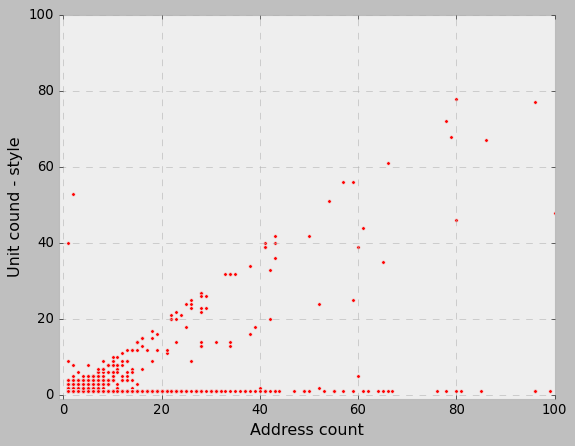

In [124]:
generate_distribution_map(sjoin_test['ADD_COUNT'], sjoin_test['UNIT_COUNT'], ["Address count", "Unit count - style"], filename="./pics/Output/add-style.png")

In [48]:
sjoin_test.head()

,index_left,UNIT_COUNT,STYLE,geometry,ADD_COUNT
LOC_ID,,,,,
F_775349_2913131,NaN,0,None,"POLYGON ((-71.05863 42.23951, -71.05916 42.239...",1
F_775713_2913360,NaN,0,None,"POLYGON ((-71.05697 42.24151, -71.05697 42.241...",1
F_776140_2913906,NaN,0,Pre-Eng Warehs,"POLYGON ((-71.05696 42.24151, -71.05696 42.241...",1
F_776785_2904919,283.0,0,Skating Arena,"MULTIPOLYGON (((-71.04710 42.22834, -71.04695 ...",2
F_777364_2914835,NaN,0,None,"POLYGON ((-71.04975 42.24545, -71.05294 42.243...",1


## Use code

In [17]:
def flter_list(l, pattern="^[019]"):
    res = []
    for e in l:
        if re.search(pattern, e): 
            res.append(True)
            # print(e)
        else: 
            res.append(False)
    return res

In [6]:
filtered_use_code_1 = state_use_code[flter_list(state_use_code['USE_CODE'])]
filtered_use_code_1.head()

,TOWN_ID,USE_CODE,USE_DESC,geometry
212,0,000,Use code not known or nor provided.,None
213,0,013,"Mixed Use (Primarily Residential, some Commerc...",None
214,0,0130,"Mixed Use (Primarily Residential, some Commerc...",None
215,0,014,"Mixed Use (Primarily Residential, some Industr...",None
216,0,0140,"Mixed Use (Primarily Residential, some Industr...",None


In [19]:
filtered_use_code_0 = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^0")]
filtered_use_code_0 = filtered_use_code_0.reset_index(drop=True)
filtered_use_code_0.head()

,TOWN_ID,USE_CODE,USE_DESC,geometry
0,0,000,Use code not known or nor provided.,None
1,0,013,"Mixed Use (Primarily Residential, some Commerc...",None
2,0,0130,"Mixed Use (Primarily Residential, some Commerc...",None
3,0,014,"Mixed Use (Primarily Residential, some Industr...",None
4,0,0140,"Mixed Use (Primarily Residential, some Industr...",None


In [57]:
print(re.search("^0", "01015"))

<re.Match object; span=(0, 1), match='0'>


In [22]:
filtered_use_code_0_res = filtered_use_code_0[flter_list(filtered_use_code_0['USE_DESC'], pattern="Residential")]
filtered_use_code_0_res = filtered_use_code_0_res.reset_index(drop=True)
filtered_use_code_0_res.head()

,TOWN_ID,USE_CODE,USE_DESC,geometry
0,0,013,"Mixed Use (Primarily Residential, some Commerc...",None
1,0,0130,"Mixed Use (Primarily Residential, some Commerc...",None
2,0,014,"Mixed Use (Primarily Residential, some Industr...",None
3,0,0140,"Mixed Use (Primarily Residential, some Industr...",None
4,0,016,"Mixed Use (Primarily Residential, some Forest)",None


In [23]:
mixed_use_res_usecode_set = set(filtered_use_code_0_res['USE_CODE'])

In [24]:
len(mixed_use_res_usecode_set)

121

In [25]:
def print_by_usecode(df, use_code_set, key_to_print="STYLE"):
    for code, df_ in df.groupby("USE_CODE"):
        if code in use_code_set:
            print("USE CODE: {}".format(code))
            print("-"*100)
            for v in df_[key_to_print]: print(v)
            print()

In [26]:
# Conclusion mix used latter
print_by_usecode(parcel_quincy, mixed_use_res_usecode_set)

USE CODE: 0130
----------------------------------------------------------------------------------------------------
Colonial
Apartments
2 Fam Conver
Colonial
Family Duplex
Conventional
Cape Cod
Conventional
Colonial
Conventional
3 Fam Flat
Colonial
Apartments
Colonial
2 Fam Conver

USE CODE: 013C
----------------------------------------------------------------------------------------------------
Ofc/Apt
Res Type Commercial
Stores/Apt Com
Ofc/Apt
Stores/Apt Com
Store
Clubs/Lodges
Commercial
Stores/Apt Com
Ofc/Apt
Res Type Commercial
Stores/Apt Com
Res Type Commercial
Stores/Apt Com
Stores/Apt Com
Store
Res Type Commercial
Res Type Commercial

USE CODE: 0310
----------------------------------------------------------------------------------------------------
Store
Office Bldg
Stores/Apt Com
High Rise Apt
Ofc/Apt
Serv Shop/Gar
Ofc/Apt
Res Type Commercial
Res Type Commercial
Stores/Apt Com
Stores/Apt Com
Res Type Commercial
Stores/Apt Com
Stores/Apt Com
Stores/Apt Com
Stores/Apt Com
Stores/

In [13]:
from texttable import Texttable

In [36]:
def print_by_usecode(df, headers=["USE_CODE", "USE_DESC", "COUNT", "INDEX"]):
    count = 1
    t = Texttable()
    t.set_cols_dtype(['t'] * len(headers))
    if headers:
        t.add_row(headers)
    for code_, df_ in df.groupby("USE_CODE"):
        # print(type(code_))
        t.add_row([code_, df_['USE_DESC'].iloc[0], len(df_), count])
        count += 1
    print(t.draw())

In [19]:
filtered_use_code_t = filtered_use_code_3

In [37]:
print_by_usecode(filtered_use_code_t)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 0101     | Mixed Use - Single Family Residential             | 36    | 1     |
+----------+---------------------------------------------------+-------+-------+
| 0102     | Residential Condominium                           | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 0103     | Mixed Use Residential - Mobile Home               | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 0104     | Mixed Use - Two-Family Residential                | 24    | 4     |
+----------+---------------------------------------------------+-------+-------+
| 0105     | Mixed Use - Three-Family Residential              | 18    | 5     |
+----------+----------------

In [38]:
filtered_use_code_0_code = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^0")]
print_by_usecode(filtered_use_code_0_code)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 000      | Use code not known or nor provided.               | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 007      | Mixed Use                                         | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 0101     | Single Fam                                        | 100   | 3     |
+----------+---------------------------------------------------+-------+-------+
| 0102     | Condo                                             | 8     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 0103     | Mobile Hom                                        | 13    | 5     |
+----------+----------------

In [39]:
filtered_use_code_1_code = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^1")]
print_by_usecode(filtered_use_code_1_code)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 1000     | Unknown [IMPUTED]                                 | 2     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 1001     | Planned Development                               | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 101      | Single Family Residential                         | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 1010     | Single Family Residential                         | 1     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 1011     | Single Family - NL                                | 23    | 5     |
+----------+----------------

In [38]:
# how to use usecode?
# 1.


In [40]:
filtered_use_code_5_code = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^5")]
print_by_usecode(filtered_use_code_5_code)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 5000     | 2ND HOME P/P                                      | 3     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 501      | Individuals, Partnerships, Associations and       | 1     | 2     |
|          | Trusts                                            |       |       |
+----------+---------------------------------------------------+-------+-------+
| 5010     | Individuals, Partnerships, Associations and       | 1     | 3     |
|          | Trusts                                            |       |       |
+----------+---------------------------------------------------+-------+-------+
| 502      | Domestic Business Corporations or a Foreign       | 1     | 4     |
|          | Corporation, as

In [41]:
filtered_use_code_9_code = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^9")]
print_by_usecode(filtered_use_code_9_code)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 900      | United States Government                          | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 9000     | United States Government                          | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 9001     | US GOVERNMENT - C                                 | 4     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 9002     | US Govt C                                         | 2     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 9003     | US Government                                     | 1     | 5     |
+----------+----------------

In [42]:
def generate_usecode_set(df):
    return set(df["USE_CODE"])

In [62]:
def check_use_code_in_df(df_use_code_set, use_code_set):
    res = set()
    for uc in use_code_set:
        if uc not in df_use_code_set:
            res.add(uc)
    coverage_rate = (len(use_code_set) - len(res))/len(use_code_set)
    print("Coverage rate: {}%".format(round(coverage_rate * 100, 2)))
    return res

In [63]:
not_used_usecode = check_use_code_in_df(generate_usecode_set(parcel_quincy), generate_usecode_set(filtered_use_code_1))

Coverage rate: 5.57%


In [68]:
filtered_use_code_not_used = state_use_code[[(i in not_used_usecode) for i in state_use_code['USE_CODE']]]
print_by_usecode(filtered_use_code_not_used)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 000      | Use code not known or nor provided.               | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 007      | Mixed Use                                         | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 0101     | Single Fam                                        | 100   | 3     |
+----------+---------------------------------------------------+-------+-------+
| 0102     | Condo                                             | 8     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 0103     | Mobile Hom                                        | 13    | 5     |
+----------+----------------

In [77]:
filtered_use_code_not_used = state_use_code[state_use_code['USE_CODE'] == "1021"]
print_by_usecode(filtered_use_code_not_used)

+----------+-------------------------+-------+-------+
| USE_CODE | USE_DESC                | COUNT | INDEX |
+----------+-------------------------+-------+-------+
| 1021     | Residential Condominium | 78    | 1     |
+----------+-------------------------+-------+-------+


In [71]:
def find_use_code_by_style(df, style):
    df_ = df[df['STYLE'] == style]
    t = Texttable()
    t.set_cols_dtype(['t'] * 2)
    t.add_row(['USE CODE', 'COUNT'])
    for uc, dff_ in df_.groupby("USE_CODE"):
        t.add_row([uc, len(dff_)])
    print(t.draw())

In [72]:
find_use_code_by_style(parcel_quincy, "Condo TH")

+----------+-------+
| USE CODE | COUNT |
+----------+-------+
| 1021     | 1500  |
+----------+-------+
| 910M     | 1     |
+----------+-------+
| 957U     | 1     |
+----------+-------+


### Using statewise dataset

In [17]:
print(len(parcel_whole.MAP_PAR_ID.unique()))
print(len(parcel_whole.LOC_ID.unique()))
print(len(parcel_whole.index))

1601883
2075206
2410194


In [35]:
cen_id_set = set(address_whole.CENTROID_ID.unique())

In [36]:
parcel_id_set = set(C.LOC_ID.unique())

In [24]:
address_set = set(address_whole.COMMUNITY_NAME.unique())
parcel_set = set(parcel_whole.CITY.unique())

In [23]:
check_tag(parcel_set, address_set)

0

In [37]:
check_tag(cen_id_set, parcel_id_set)

1924069

In [57]:
print(check_geometry(parcel_whole[:10000], "LOC_ID"))
print(check_geometry(address_whole[:10000], "CENTROID_ID"))

25

## Test section, Garbage for now

In [21]:
def construct_df_map(df, keyword="COMMUNITY_NAME"):
    m = {}
    for name, df in df.groupby(keyword):
        m.update({name: df})
    return m

In [22]:
address_cityname_df_map = construct_df_map(address_whole)

In [24]:
def join_two_dataset_state_map(parcel_df, address_df_map, keyword="CITY"):
    start_time = datetime.now()
    
    m = {}
    for name, p_df in parcel_df.groupby(keyword):
        start_time_2 = datetime.now()

        a_df = address_df_map[address_df_map["COMMUNITY_NAME"] == name]
        join_two_dataset_map(a_df, p_df, m, "LOC_ID")
        print("%s, cost: %.2dms" %(name, (datetime.now() - start_time_2).total_seconds() * 1000))
        print("res length: %d" %(len(m)))

    end_time = datetime.now()
    print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))
    return m


In [110]:
gdf = gpd.GeoDataFrame()
print(gdf.empty)

True


In [101]:
parcel_whole.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
def join_state_data(address_whole, parcel_whole):
    start_time = datetime.now()
    res = join_two_dataset(address_whole, parcel_whole, "LOC_ID")
    end_time = datetime.now()
    print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))
    return res

In [20]:
joined_state_1 = join_state_data(address_whole, parcel_whole)

Time cost: 4064548.05ms


In [23]:
to_geofeather(joined_state_1.reset_index(), "./data/processed.feather")

In [24]:
len(joined_state_1.index)

1834283

In [27]:
joined_state_1_conv = joined_state_1.to_crs("EPSG:4326")
mass_heat_map = draw_debug_heatmap(joined_state_1_conv.geometry, joined_state_1_conv.ADD_COUNT, 12)
mass_heat_map.save("./maps/mass_heatmap.html")

In [ ]:
joined_state_2 = join_two_dataset_state_map(parcel_whole, address_whole)

ABINGTON, cost: 2718ms
res length: 4475
ACTON, cost: 3823ms
res length: 10786
ACUSHNET, cost: 2239ms
res length: 14434
ADAMS, cost: 1884ms
res length: 17384
AGAWAM, cost: 5109ms
res length: 25982
ALFORD, cost: 363ms
res length: 26321
AMESBURY, cost: 3005ms
res length: 31120
AMHERST, cost: 3311ms
res length: 36022
ANDOVER, cost: 6095ms
res length: 45979
AQUINNAH, cost: 486ms
res length: 46504
ARLINGTON, cost: 7261ms
res length: 58019
ASHBURNHAM, cost: 1697ms
res length: 60626
ASHBY, cost: 851ms
res length: 61827
ASHFIELD, cost: 648ms
res length: 62639
ASHLAND, cost: 2706ms
res length: 66887
ATHOL, cost: 2510ms
res length: 70856
ATTLEBORO, cost: 7412ms
res length: 82810
AUBURN, cost: 3524ms
res length: 88632
AVON, cost: 1063ms
res length: 90218
AYER, cost: 1509ms
res length: 92402
BARNSTABLE, cost: 2827ms
res length: 94399
BARRE, cost: 1337ms
res length: 96268
BECKET, cost: 1337ms
res length: 98088
BEDFORD, cost: 2585ms
res length: 102232
BELCHERTOWN, cost: 3106ms
res length: 107138
BELL

In [23]:
address_whole.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3656134 entries, 0 to 3656133
Data columns (total 25 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   CENTROID_ID               object  
 1   FULL_NUMBER_STANDARDIZED  object  
 2   ADDRESS_NUMBER_PREFIX     object  
 3   ADDRESS_NUMBER            float64 
 4   ADDRESS_NUMBER_SUFFIX     object  
 5   ADDRESS_NUMBER_2_PREFIX   object  
 6   ADDRESS_NUMBER_2          float64 
 7   ADDRESS_NUMBER_2_SUFFIX   object  
 8   STREET_NAME               object  
 9   FLOOR                     object  
 10  UNIT                      object  
 11  MASTER_ADDRESS_ID         int64   
 12  STREET_NAME_ID            int64   
 13  REL_LOC                   object  
 14  SITE_ID                   float64 
 15  BUILDING_NAME             object  
 16  GEOGRAPHIC_TOWN_ID        float64 
 17  COMMUNITY_ID              int64   
 18  COMMUNITY_NAME            object  
 19  GEOGRAPHIC_TOWN           object  

### Using Quincy dataset

In [12]:
#Merge using goepandas.sjoin
start_time = datetime.now()

joined_test_quincy_2k = gpd.sjoin(address_quincy, parcel_quincy_test_2k, how="inner", op="within")
# newQuincy = gpd.sjoin(address_quincy, parcel_quincy[['LOC_ID', 'geometry']], how='left', op='within')
# joined_test = gpd.sjoin(parcel_quincy_converted, address_quincy_converted, how="inner", op="within")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 291.07ms


In [14]:
parcel_quincy_test_2k_conv = parcel_quincy_test_2k.to_crs("EPSG:4326")
joined_test_quincy_2k_conv = joined_test_quincy_2k.to_crs("EPSG:4326")

In [19]:
joined_test_quincy_2k_conv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3458 entries, 2120189 to 2225326
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               3458 non-null   object  
 1   FULL_NUMBER_STANDARDIZED  3458 non-null   object  
 2   ADDRESS_NUMBER_PREFIX     1 non-null      object  
 3   ADDRESS_NUMBER            3458 non-null   float64 
 4   ADDRESS_NUMBER_SUFFIX     22 non-null     object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               3458 non-null   object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      1167 non-null   object  
 11  MASTER_ADDRESS_ID         3458 non-null   int64   
 12  STREET_NAME_ID            3458 non-null   int64   
 13  REL_LOC                   1 non

In [16]:
test_m_1 = draw_debug_plot(joined_test_quincy_2k_conv.geometry, parcel_quincy_test_2k_conv.geometry)

In [18]:
test_m_1.save("maps/test_m_1.html")

In [65]:
test_drop = parcel_quincy_2k.drop_duplicates(["MAP_PAR_ID"])

In [67]:
test_drop.MAP_PAR_ID.value_counts()

5190-22-A       1
5012-10-555     1
5056-61-760     1
4001-27-        1
6154-62-42      1
               ..
1168-44-C       1
6018-25-A       1
1033-20-76      1
4125-17-14      1
6017B-26-235    1
Name: MAP_PAR_ID, Length: 1308, dtype: int64

In [32]:
parcel_quincy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24247 entries, 207 to 2406350
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MAP_PAR_ID  17102 non-null  object  
 1   LOC_ID      24247 non-null  object  
 2   POLY_TYPE   24247 non-null  object  
 3   MAP_NO      24241 non-null  object  
 4   SOURCE      24247 non-null  object  
 5   PLAN_ID     0 non-null      object  
 6   LAST_EDIT   24247 non-null  int64   
 7   BND_CHK     143 non-null    object  
 8   NO_MATCH    24247 non-null  object  
 9   TOWN_ID     24247 non-null  int64   
 10  PROP_ID     24247 non-null  object  
 11  BLDG_VAL    24247 non-null  int64   
 12  LAND_VAL    24247 non-null  int64   
 13  OTHER_VAL   24247 non-null  int64   
 14  TOTAL_VAL   24247 non-null  int64   
 15  FY          24247 non-null  int64   
 16  LOT_SIZE    24247 non-null  float64 
 17  LS_DATE     24247 non-null  object  
 18  LS_PRICE    24247 non-null  int64 

In [59]:
parcel_quincy_2k = parcel_quincy[:2000]

In [68]:
#Merge using goepandas.sjoin
start_time = datetime.now()

# joined_quincy_2k = gpd.sjoin(address_quincy, parcel_quincy_2k, how="inner", op="within")
joined_quincy_2k = gpd.sjoin(address_quincy, test_drop, how="inner", op="within")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 266.06ms


In [80]:
joined_quincy_2k_count = count_address(joined_quincy_2k)

In [69]:
joined_quincy_2k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5137 entries, 2065885 to 2303588
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               5137 non-null   object  
 1   FULL_NUMBER_STANDARDIZED  5137 non-null   object  
 2   ADDRESS_NUMBER_PREFIX     1 non-null      object  
 3   ADDRESS_NUMBER            5137 non-null   float64 
 4   ADDRESS_NUMBER_SUFFIX     17 non-null     object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               5137 non-null   object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      3233 non-null   object  
 11  MASTER_ADDRESS_ID         5137 non-null   int64   
 12  STREET_NAME_ID            5137 non-null   int64   
 13  REL_LOC                   0 non

In [83]:
joined_quincy_2k_count_conv = joined_quincy_2k_count.to_crs("EPSG:4326")
test_drop_conv = test_drop.to_crs("EPSG:4326")

In [91]:
test_m_2 = draw_debug_plot(joined_quincy_2k_count_conv.geometry, test_drop_conv.geometry, joined_quincy_2k_count_conv.ADD_COUNT)
test_m_2.save("./maps/test_m_2.html")

In [100]:
parcel_quincy_conv = parcel_quincy.to_crs("EPSG:4326")
test_m_3 = draw_debug_plot([], parcel_quincy_conv.geometry)
test_m_3.save("./maps/quincy_parcel.html")

In [35]:
len(address_quincy[address_quincy["CENTROID_ID"] == "M_242902_889211"])

410

In [53]:
observe_data = parcel_quincy_2k[parcel_quincy_2k["MAP_PAR_ID"] == "4032-20-16MGT"]

In [50]:
# count polygons with same MAP_PAR_ID
def count_polygons(polygons):
    p = None
    count = 1
    for polygon in polygons:
        if not p:
            p = polygon
            continue
        if p != polygon:
            p = polygon
            count += 1
    print(count)

In [54]:
count_polygons(observe_data.geometry)

1


### Whole quincy

In [114]:
quincy_join = join_two_dataset(address_quincy, parcel_quincy)

Time cost: 2224.01ms


In [118]:
calculate_coverage(quincy_join, parcel_quincy.drop_duplicates("MAP_PAR_ID"))

97.79

In [117]:
quincy_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 15315 entries, 1002-1-103 to 6171-24-ML20B
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               15315 non-null  object  
 1   FULL_NUMBER_STANDARDIZED  15315 non-null  object  
 2   ADDRESS_NUMBER_PREFIX     5 non-null      object  
 3   ADDRESS_NUMBER            15315 non-null  float64 
 4   ADDRESS_NUMBER_SUFFIX     106 non-null    object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               15315 non-null  object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      2037 non-null   object  
 11  MASTER_ADDRESS_ID         15315 non-null  int64   
 12  STREET_NAME_ID            15315 non-null  int64   
 13  REL_LOC                   

In [119]:
quincy_join_conv = quincy_join.to_crs("EPSG:4326")

In [25]:
quincy_heat_map = draw_debug_heatmap(joined_state_1.geometry, joined_state_1.ADD_COUNT, 15)
quincy_heat_map.save("./maps/mass_heatmap.html")